# Clustering - Introduction
This notebook is a third part of [eargasm-spotify](https://github.com/adamsiemaszkiewicz/eargasm-music) repository meant to cluster the playlist and track information from the [eargasm music channel](https://open.spotify.com/user/eargasmusic?si=HtTLbkG6QoqkdKU3uTRjAQ) at Spotify.

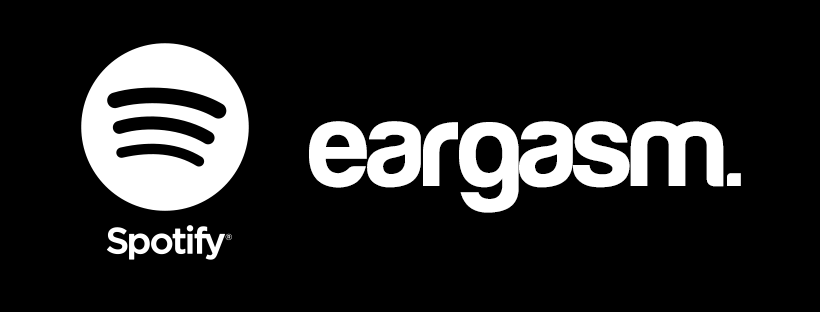

# Set up environment

## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/eargasm-music/

/content/gdrive/My Drive/Colab Notebooks/eargasm-music


In [3]:
!ls

catboost_info		      eargasm_DataExploration.ipynb  files
eargasm_Classification.ipynb  eargasm_DataRetrieval.ipynb    README.md


In [4]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.5MB/s 


## Import libraries and functions
Let's import all the libraries and function we're gonna use throughout the notebook.

### Notebook
- `tqdm.notebook` `tqdm` - Progress bars

In [5]:
from tqdm.notebook import tqdm
import timeit

### Data science
- `pandas` - data manipulation & analysis
- `pd.options.mode.chained_assignment` - switch off warning for chained_assignment
- `numpy` - linear algebra

In [6]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

### Visualization
- `matplotlib.pyplot` - basic visualizations
- `plotly` - advanced visualizations
- `plotly.express` - fast vizualizations
- `plotly.graph_objects` - more control over plotly figures

In [7]:
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

## Machine learning

In [8]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
# import category_encoders as ce 


# Feature engineering

## Load data
Let's load the data fetched from the [Eargasm Music](https://open.spotify.com/user/eargasmusic?si=cz4VzEi1RgaUup_g8-UnEg) Spotify channel using `eargasm_retrieve-data.ipynb`. The data set consists of the tracks with their features as well as a playlist name label.

In [9]:
final_df = pd.read_csv('files/final_df.csv', index_col=0)
final_df.head()

,track_id,track_artist,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,key_confidence,mode,mode_confidence,number_of_sections,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1ua6hBq18qZLyprXjMcpyf,Virgil Howe,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,42,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,eargasm | breathe easy,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.292,0.0,0.398,12.0,86.502,0.160,4.0,1.000
1,42VpxSdGQgnV1UJkWeGYkA,Cass McCombs,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,51,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,eargasm | breathe easy,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.743,0.0,0.453,12.0,98.003,0.583,4.0,1.000
2,1g8A166soQjwl1ihqBWKGW,The Slow Revolt,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,NaN,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,eargasm | breathe easy,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,0.655,1.0,0.368,12.0,85.036,0.325,4.0,0.979
3,6cAVWcj8TQ5yR2T6BZjnOg,Dirty Nice,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,NaN,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,eargasm | breathe easy,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,0.547,1.0,0.560,12.0,125.088,0.476,4.0,0.845
4,3YA509E9ki7a3Ic9cf25Vt,Alex Ebert,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,eargasm | breathe easy,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,0.905,1.0,0.753,12.0,170.556,0.183,4.0,0.799


## Select features

In [10]:
features_to_keep = [
                    # 'track_artist',
                    'track_duration',
                    'track_popularity',
                    # 'track_releasedate',
                    'track_genre',
                    'acousticness',
                    'danceability',
                    'energy',
                    'instrumentalness',
                    'liveness',
                    'speechiness',
                    'valence',
                    'key',
                    # 'key_confidence',
                    'mode',
                    # 'mode_confidence',
                    # 'number_of_sections',
                    'tempo',
                    # 'tempo_confidence',
                    'time_signature',
                    # 'time_signature_confidence',
                    'track_playlist'
                    ]
df_encoded = final_df[features_to_keep]

## Features encoding

In [11]:
def cut_into_categories(feature_name, number_of_categories):

  df_encoded[feature_name] = final_df[feature_name]  
  df_encoded[feature_name] = pd.cut(df_encoded[feature_name], number_of_categories)

  ranges = df_encoded[feature_name].unique()
  ranges.sort_values(inplace=True)

  for n, value in enumerate(ranges):
    df_encoded.loc[df_encoded[feature_name] == value, feature_name+'_en'] = n+1

  df_encoded.drop(columns=[feature_name], inplace=True)
  df_encoded.rename(columns = {feature_name+'_en': feature_name}, inplace = True)

  return df_encoded

In [12]:
def fill_nans(feature_name):
  df_encoded[feature_name].fillna(int(df_encoded[feature_name].mean()), inplace=True)
  return df_encoded

In [13]:
df_encoded['track_duration'] = final_df['track_duration'] # reset value
df_encoded['track_duration'] = df_encoded['track_duration'].apply(lambda x: x/60000)

cut_into_categories('track_duration', 10)
cut_into_categories('track_popularity', 10)
cut_into_categories('acousticness', 10)
cut_into_categories('danceability', 10)
cut_into_categories('energy', 10)
cut_into_categories('instrumentalness', 10)
cut_into_categories('liveness', 10)
cut_into_categories('speechiness', 10)
cut_into_categories('valence', 10)
cut_into_categories('tempo', 15)

df_encoded['track_genre'].fillna('unknown', inplace=True)
df_encoded['tempo'].fillna(int(df_encoded['tempo'].mean()), inplace=True)


fill_nans('key')
fill_nans('mode')
fill_nans('time_signature')

df_encoded = df_encoded.dropna()
df_encoded.head()

,track_genre,key,mode,time_signature,track_playlist,track_duration,track_popularity,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo
0,unknown,9.0,0.0,4.0,eargasm | breathe easy,4.0,6.0,4.0,5.0,5.0,3.0,1.0,1.0,4.0,4.0
1,alternative country,7.0,0.0,4.0,eargasm | breathe easy,4.0,7.0,4.0,7.0,6.0,1.0,4.0,1.0,8.0,5.0
2,vapor pop,1.0,1.0,4.0,eargasm | breathe easy,3.0,1.0,2.0,6.0,8.0,9.0,2.0,1.0,7.0,4.0
3,unknown,11.0,1.0,4.0,eargasm | breathe easy,3.0,1.0,8.0,7.0,6.0,1.0,1.0,2.0,4.0,7.0
4,alternative americana,0.0,1.0,4.0,eargasm | breathe easy,4.0,7.0,3.0,5.0,6.0,1.0,2.0,1.0,6.0,10.0


# Single label classification

## Train/test split

In [14]:
X = df_encoded[['track_duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'tempo']]
y = df_encoded['track_playlist']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Model selection

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis


list_of_classifiers = [
                       LogisticRegression(),
                       KNeighborsClassifier(),
                       svm.SVC(),
                      #  GaussianProcessClassifier(),
                       DecisionTreeClassifier(),
                       MLPClassifier(),
                       RandomForestClassifier(),
                       AdaBoostClassifier(),
                       GaussianNB(),
                       QuadraticDiscriminantAnalysis(),
                       LinearDiscriminantAnalysis()
                      ]

In [17]:
start = timeit.default_timer()

for classifier in list_of_classifiers:
  
  clf = classifier
  clf.fit(X_train, y_train)
  print('{} \nTrain set score: {} \nTest set score: {} \nMean score: {}\n\n'.format(str(classifier).split('(')[0],
                                                                                    clf.score(X_train, y_train),
                                                                                    clf.score(X_test, y_test),
                                                                                    (clf.score(X_train, y_train)+clf.score(X_test, y_test))/2))

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression 
Train set score: 0.20847145488029467 
Test set score: 0.18322295805739514 
Mean score: 0.1958472064688449


KNeighborsClassifier 
Train set score: 0.3443830570902394 
Test set score: 0.12472406181015452 
Mean score: 0.23455355945019696


SVC 
Train set score: 0.23646408839779007 
Test set score: 0.19426048565121412 
Mean score: 0.2153622870245021


DecisionTreeClassifier 
Train set score: 0.7219152854511971 
Test set score: 0.05739514348785872 
Mean score: 0.3896552144695279




/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier 
Train set score: 0.24530386740331492 
Test set score: 0.17880794701986755 
Mean score: 0.21205590721159123


RandomForestClassifier 
Train set score: 0.7219152854511971 
Test set score: 0.10485651214128035 
Mean score: 0.4133858987962387


AdaBoostClassifier 
Train set score: 0.11933701657458563 
Test set score: 0.10264900662251655 
Mean score: 0.1109930115985511


GaussianNB 
Train set score: 0.19815837937384898 
Test set score: 0.17218543046357615 
Mean score: 0.18517190491871255


QuadraticDiscriminantAnalysis 
Train set score: 0.21620626151012892 
Test set score: 0.16225165562913907 
Mean score: 0.189228958569634


LinearDiscriminantAnalysis 
Train set score: 0.20626151012891344 
Test set score: 0.18543046357615894 
Mean score: 0.19584598685253618


Runtime: 10.251153840000029 seconds.


## Random Forest

In [18]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print('Train set score: {} \n\nTest set score: {}'.format(clf.score(X_train, y_train),
                                                          clf.score(X_test, y_test)))

Train set score: 0.7219152854511971 

Test set score: 0.11368653421633554


In [22]:
from sklearn.model_selection import GridSearchCV

start = timeit.default_timer()

parameters = {
              'n_estimators': [10, 30, 60, 90, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5],
              'max_features': [1, 2, 3]
             }
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters)
search = clf.fit(X_train, y_train)

print(search.best_params_)

print('Train set score: {} \nTest set score: {}'.format(clf.score(X_train, y_train),
                                                          clf.score(X_test, y_test)))

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 1, 'n_estimators': 90}
Train set score: 0.25451197053407 

Test set score: 0.18984547461368653
Runtime: 22.364194145 seconds.


CROSS VALIDATION https://scikit-learn.org/stable/modules/cross_validation.html

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}
Train set score: 0.24898710865561693 
Test set score: 0.19536423841059603

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 1, 'n_estimators': 90}
Train set score: 0.25451197053407 

Test set score: 0.18984547461368653

In [20]:
fdghs sdfg

SyntaxError: ignored

## Support Vector Machines

### Basic model

In [ ]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)


In [ ]:
print('Train set score: {} \n\nTest set score: {}'.format(clf.score(X_train, y_train),
                                                          clf.score(X_test, y_test)))

### Hyper parameter tuning

#### Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

start = timeit.default_timer()

svc = svm.SVC()
distributions = dict(
    C=range(1,10),
    kernel=['linear', 'poly', 'rbf', 'sigmoid'],
    degree=range(0,10),
    gamma=['scale', 'auto'],
    decision_function_shape=['ovo', 'ovr']
                    )
clf = RandomizedSearchCV(svc, distributions)
search = clf.fit(X_test, y_test)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
search.best_params_

In [ ]:
search.best_estimator_.score(X_train, y_train)

In [ ]:
search.best_estimator_.score(X_test, y_test)

#### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

start = timeit.default_timer()

parameters = {'C':range(1,6),
              'kernel': ['linear', 'rbf', 'poly'],
              'degree': range(1,6),
              'decision_function_shape': ['ovo', 'ovr']
             }
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
search = clf.fit(X_train, y_train)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
search.best_params_

In [ ]:
search.best_estimator_.score(X_train, y_train)

In [ ]:
search.best_estimator_.score(X_test, y_test)

### Tuned model

In [ ]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)
print('Train set score: {} \n\nTest set score: {}'.format(clf.score(X_train, y_train), clf.score(X_test, y_test)))

### Predictions

In [ ]:
def probabilities(number):
  df = pd.DataFrame({'class': clf.classes_, 'probability': clf.predict_proba(X_test)[number]})
  df = df.sort_values(by='probability', ascending=False).head(n=3)
  
  index_number = X_test.index[number]
  prediction = clf.predict(X_test)[number], final_df.loc[index_number]['track_url']
  
  id = final_df.loc[index_number]['track_id']
  truth = final_df.loc[final_df['track_id'] == id]['track_playlist']
  
  return print('Prediction: \n {}\n\n Probabilities: \n {}\n\n Truth: {}'.format(prediction, df, truth))

In [ ]:
random_number = np.random.randint(0, X_test.shape[0])
probabilities(random_number)

In [ ]:
# SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
#     decision_function_shape='ovo', degree=1, gamma='scale', kernel='linear',
#     max_iter=-1, probability=False, random_state=None, shrinking=True,
#     tol=0.001, verbose=False)

0.2165
0.1898

In [ ]:
clf = svm.SVC(
              probability=True,
              C=3,
              decision_function_shape='ovo',
              degree=1,
              gamma='scale',
              kernel='linear'
             )
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, test_scores = learning_curve(clf, 
#                                                         X, 
#                                                         y,
#                                                         # Number of folds in cross-validation
#                                                         cv=5,
#                                                         # Evaluation metric
#                                                         scoring='accuracy',
#                                                         # Use all computer cores
#                                                         n_jobs=-1, 
#                                                         # 50 different sizes of the training set
#                                                         train_sizes=np.linspace(0.01, 1.0, 5))

In [ ]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
  def probabilities(number):
    df = pd.DataFrame({'class': clf.classes_, 'probability': clf.predict_proba(X_test)[number]})
    df = df.sort_values(by='probability', ascending=False).head(n=3)

    index_number = X_test.index[number]
    prediction = clf.predict(X_test)[number], final_df.loc[index_number]['track_url']

    id = final_df.loc[index_number]['track_id']
    truth = final_df.loc[final_df['track_id'] == id]['track_playlist']
    return print('Prediction: \n {}\n\n Probabilities: \n {}\n\n Truth: {}'.format(prediction, df, truth))

In [ ]:
random_number = np.random.randint(0, X_test.shape[0])
probabilities(random_number)

## EVALUATION & MULTILABEL
- https://medium.com/@hfdtsinghua/calculate-mean-average-precision-map-for-multi-label-classification-b082679d31be
- https://www.kaggle.com/vikashrajluhaniwal/multi-label-classification-for-tag-predictions
- https://www.kaggle.com/roccoli/multi-label-classification-with-sklearn
- https://towardsdatascience.com/a-brief-introduction-to-support-vector-machine-adf0f103a80f
- https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
- https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
- https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

## Multilabel tryout

In [ ]:
!pip install scikit-multilearn

In [ ]:
from skmultilearn.adapt import MLkNN

## Remove outliers

In [ ]:
df = df_encoded.drop(columns=['track_genre', 'track_playlist'])
df

In [ ]:
from scipy import stats

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df

In [ ]:
df_nooutliers = df.merge(df_encoded, how='inner', left_index=True, right_index=True, copy=False)
for column in df_nooutliers.columns:
  if column.endswith('_x'): df_nooutliers.rename(columns={column: column.rstrip('_x')}, inplace=True) #df_nooutliers.rename(columns={column: }) 
  elif column.endswith('_y'): df_nooutliers.drop(columns=[column], inplace=True)
df_nooutliers


In [ ]:
X = df_nooutliers[['track_duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'tempo']]
y = df_nooutliers['track_playlist']

In [ ]:
from sklearn import svm

clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train,y_train)
clf.score(X_train, y_train)


In [ ]:
train_score = []
test_score = []
for neighbors in tqdm(range(1,100)):
  clf=KNeighborsClassifier(n_neighbors=neighbors)
  clf.fit(X_train, y_train)
  train_score.append(clf.score(X_train, y_train))
  test_score.append(clf.score(X_test, y_test))


In [ ]:
plt.scatter(x=train_score, y=test_score)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

In [ ]:
train_score = []
test_score = []
for depth in tqdm(range(1,100)):
  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)
  train_score.append(clf.score(X_train, y_train))
  test_score.append(clf.score(X_test, y_test))


In [ ]:
plt.scatter(x=train_score, y=test_score)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
train_score = []
test_score = []
for estimators in tqdm(range(1,200)):
  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)
  train_score.append(clf.score(X_train, y_train))
  test_score.append(clf.score(X_test, y_test))


In [ ]:
plt.scatter(x=train_score, y=test_score)

## PCA

In [ ]:
X = df_nooutliers[['track_duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'tempo']]
y = df_nooutliers['track_playlist']

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit_transform(X)
pca

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca, y, random_state=0)
plt.figure(dpi=120)
plt.scatter(x=pca[:,0], y=pca[:,1], c=pca[:,2])
# plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='Poisonous', s=2)
plt.legend()
plt.title('Mushroom Data Set\nFirst Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')

## Multilabel classification
https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value/45088911

In [ ]:
# columns = final_df.columns.to_list()
# columns.remove('track_playlist')

columns = [
           'track_id',
           'track_url',
           'acousticness',
           'danceability',
           'instrumentalness',
           'valence',
           'tempo',
           'track_duration',
           'track_popularity',
           'track_playlist'
          ]

# df_nodup = final_df.copy()
df = final_df.copy()[columns]

df = df.groupby(['track_id', 'track_url', 'acousticness', 'danceability', 'instrumentalness', 'valence', 'tempo', 'track_duration', 'track_popularity']).agg(list).reset_index()
df



In [ ]:
X = df.drop(columns=['track_id', 'track_playlist', 'track_url'])
y = df['track_playlist']

In [ ]:
print(X.shape, y.shape)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y = pd.DataFrame(mlb.fit_transform(y), columns=mlb.classes_)

# y_converted = mlb.fit_transform(y)
# y_converted
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier.fit(X_train, y_train)
# predict
# predictions = classifier.predict(X_test)
# # accuracy
# print("Accuracy = ",accuracy_score(y_test,predictions))
# print("\n")



In [ ]:
classifier.score(X_test, y_test)

In [ ]:
classifier.predict(X_test)[0]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
# cross_val_score(clf, X_test, y_test, cv=10).mean()


In [ ]:
y_pred = pd.Series(mlb.inverse_transform(clf.predict(X_test)))
y_pred[0]


## Multi output

In [ ]:
X = df_encoded[['acousticness', 'danceability', 'instrumentalness', 'valence', 'tempo', 'track_duration', 'track_popularity']]
y = df_encoded['track_playlist']

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
# mlb.classes_

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)

# Y_train = mlb.fit_transform(y_train)
# Y_test = mlb.fit_transform(y_test)
# Y_train[0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
clf.predict_proba(X_test)

## Shit

In [ ]:
# X = df_encoded.drop('track_playlist', axis='columns')
# y = df_encoded['track_playlist']

In [ ]:
# ordinal_categories = [
#                       'track_duration',
#                       'track_popularity',
#                       'acousticness',
#                       'danceability',
#                       'energy',
#                       'instrumentalness',
#                       'liveness',
#                       'speechiness',
#                       'valence',
#                       'tempo'
#                      ]

# nominal_categories = [
#                       'track_genre',
#                       'key',
#                       'mode',
#                       'time_signature'
#                      ]
# column_transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False, handle_unknown = 'ignore'), nominal_categories),
#     remainder='passthrough'
#     )
# column_transformer.fit_transform(X)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()

In [ ]:
# pipe = make_pipeline(column_transformer, knn)

In [ ]:
# cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

In [ ]:
# ohe = OneHotEncoder(sparse=False)
# ohe.fit_transform(X_encoded[['track_genre']]).shape
# ohe.categories_
# # pe = OrdinalEncoder()



In [ ]:
# encoder = ce.BinaryEncoder(cols=['track_artist', 'track_genre'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# X_encoded['track_duration'] = X_encoded['track_duration'].apply(lambda x: int(x/1000))

# X_encoded['tempo'].fillna(X_encoded['tempo'].mean(), inplace=True)
# X_encoded['tempo'] = X_encoded['tempo'].apply(lambda x: int(x))
# X_encoded.head()

In [ ]:
# X_encoded['track_releasedate_year'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).year)
# X_encoded['track_releasedate_month'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).month)
# X_encoded.drop(columns=['track_releasedate'], inplace=True)
# X_encoded.head()

In [ ]:
# encoder = ce.OneHotEncoder(cols=['key', 'mode', 'number_of_sections', 'time_signature'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# features=['key', 'mode', 'tempo', 'time_signature']
# for feat in features:
#   X_encoded[feat].fillna(X_encoded[feat].mean(), inplace=True)

# References
- https://contrib.scikit-learn.org/category_encoders/
- https://www.datacamp.com/community/tutorials/categorical-data
- https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
- https://opendatascience.com/a-machine-learning-deep-dive-into-my-spotify-data/
- https://www.kaggle.com/lowkimhoe/prediction-model-on-spotify-classification